In [92]:
import numpy as np 
import pandas as pd
from mlp import mlp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import copy
import datetime

In [93]:
df = pd.read_csv("./dataset/BTC-USD.csv")[-500:]
print "First:", df.Date.values[0]
print "Last:", df.Date.values[-1]
Dates = pd.to_datetime(df.Date)
print df.head(), "\n", len(df)
days = 9
span = 40

First: 2017-02-27
Last: 2018-07-17
            Date         Open         High          Low        Close  \
2417  2017-02-27  1171.579956  1195.819946  1164.270020  1188.829956   
2418  2017-02-28  1188.829956  1208.219971  1175.750000  1189.270020   
2419  2017-03-01  1189.270020  1225.040039  1154.550049  1222.660034   
2420  2017-03-02  1222.660034  1286.979980  1211.959961  1255.469971   
2421  2017-03-03  1255.469971  1291.349976  1250.800049  1283.300049   

        Adj Close    Volume  
2417  1188.829956  42035366  
2418  1189.270020  60371869  
2419  1222.660034  61964760  
2420  1255.469971  98040639  
2421  1283.300049  85876262   
500


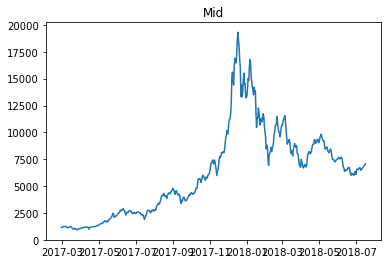

(500,)
(460,)


In [94]:
alll = ((df.High + df.Low)/2.)
plt.plot(Dates, alll)
plt.title("Mid")
plt.show()
print alll.shape
mid = alll[:-span]
print mid.shape

## Regressor

In [103]:
reg =  MLPRegressor(algorithm='adam', alpha=0.01, hidden_layer_sizes=(100), random_state=None,
                verbose=False, max_iter=30000, shuffle=False, tol=1e-10, early_stopping=False,
                   momentum=0.9)

In [104]:
# return the time series till the day before to the day after
def series_creator(X, y=None, length=30, foresee_days=0):
    m = X.shape[0]
    X_n = []
    y_n = []
    for i in xrange(length, (m-foresee_days)):
        X_n.append(X[(i-length):i])
        if y is not None:
            y_n.append(y[i + foresee_days])
    
    if y is None:
        return np.vstack((X_n))
    else:
        return np.vstack((X_n)), np.hstack((y_n))
a = np.array([1,   2,  3,  4,  5,  6,  7,  8])
y = np.array([11, 12, 13, 14, 15, 16, 17, 18])
print series_creator(a, y, length=2, foresee_days=3)


(array([[1, 2],
       [2, 3],
       [3, 4]]), array([16, 17, 18]))


In [105]:
X, y = series_creator(X=mid.values, y=mid.values, length=span, foresee_days=days) 
print X.shape, y.shape
scaler = MinMaxScaler() #just need to be defined here, aS THE Xs are equal
scaler.fit(X)
X_std = scaler.transform(X)
lenx = np.arange(X.shape[0]).reshape(-1,1)
leny = np.arange(y.shape[0]).reshape(-1,1)
print lenx.shape, leny.shape
X_std = np.hstack((lenx, X_std))
y = np.hstack((leny, y.reshape(-1,1)))
print X_std.shape, y.shape

(411, 40) (411,)
(411, 1) (411, 1)
(411, 41) (411, 2)


In [98]:
X_train_std, X_a, y_train, y_a = train_test_split(X_std, y, test_size=0.30, random_state=42)
X_test_std, X_validation_std, y_test, y_validation = train_test_split(X_a, y_a, test_size=0.5, random_state=42)

X_train_std = X_train_std[np.argsort(X_train_std[:, 0]), 1:]
X_validation_std = X_validation_std[np.argsort(X_validation_std[:, 0]), 1:]
X_test_std = X_test_std[np.argsort(X_test_std[:, 0]), 1:]

y_train = y_train[np.argsort(y_train[:,0 ]), 1]
y_validation = y_validation[np.argsort(y_validation[:,0 ]), 1]
y_test =  y_test[np.argsort(y_test[:,0 ]), 1]

print X_train_std.shape, X_validation_std.shape
print y_train.shape, y_validation.shape
generic_x = np.arange(len(y_test))

(287, 40) (62, 40)
(287,) (62,)


In [106]:
def mean_error(yreal, ypred):
    abs_diff = np.abs(yreal - ypred)
    return abs_diff.sum(axis=0)/float(abs_diff.shape[0])

def best_finder(ann, tot, mmin=-1000):
    ft = mmin
    for i in xrange(tot):
        ann.fit(X_train_std, y_train)
        mf = ann.score(X_validation_std, y_validation)
        #print i
        if mf>ft:
            print "better one found:", mf, i,"mean error:", mean_error(y_validation, ann.predict(X_validation_std))
            ft = mf
            my = copy.copy(ann)
    return my

In [107]:
reg = best_finder(reg, 1)
reg1 = copy.copy(reg)
print "final test", reg1.score(X_test_std, y_test)


better one found: 0.8421854043666455 0 mean error: 1122.4241578691833
final test 0.8496805229889642


Mean error: 979.54


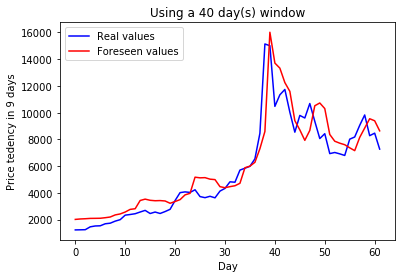

Pearson coef:  0.9287572787845614


In [109]:
pred = reg1.predict(X_test_std)
print"Mean error: %.2f"%mean_error(y_test, pred)
plt.plot(y_test, c='b', label="Real values")
plt.plot(pred, c='r', label="Foreseen values")
plt.title("Using a %s day(s) window"%span)
plt.xlabel("Day")
plt.ylabel("Price tedency in %s days"%days)
plt.legend(loc='best')
plt.show()
print "Pearson coef: ", np.corrcoef(pred, y_test)[0,1] 

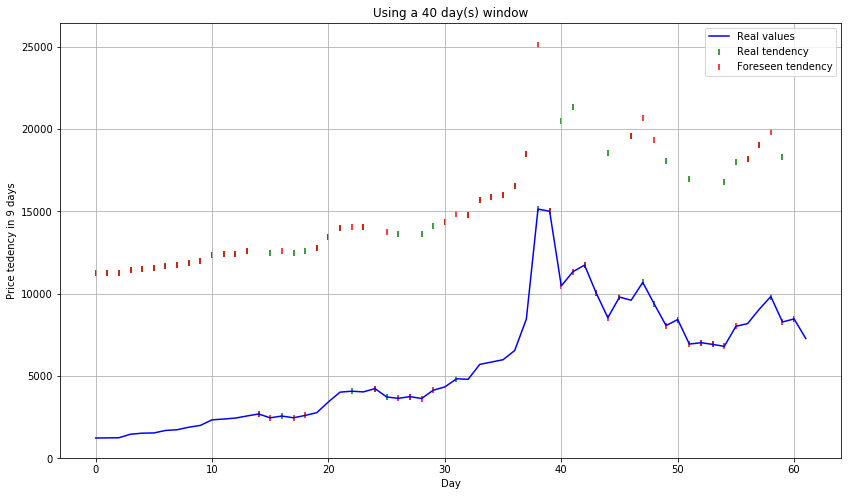

final ac: 84.97%
Delta tendency accuracy: 73.77%


In [110]:
adj=10000
y_diff = y_test[1:] - y_test[:-1]
y_bin = np.where(1, y_diff>0, 0)
my = y_test[:-1] + adj*y_bin

pred_diff =  pred[1:] - pred[:-1]
pred_bin = np.where(1, pred_diff>0, 0)

my2 = y_test[:-1] + adj*pred_bin
plt.figure(figsize = (14,8))
plt.plot(y_test, c='b', label="Real values")


plt.scatter(generic_x[:-1], my, c='g',marker="|", label="Real tendency")
plt.scatter(generic_x[:-1], my2, c='r',marker="|", label="Foreseen tendency")
plt.grid()

plt.title("Using a %s day(s) window"%span)
plt.xlabel("Day")
plt.ylabel("Price tedency in %s days"%days)
plt.legend(loc='best')
plt.show()

print "final ac: %.2f%%"%(100*reg1.score(X_test_std, y_test))
c_diff = pred[1:] - y_test[:-1]
c_bin = np.where(1, c_diff>0, 0)
trend = pred_bin.shape[0]-np.count_nonzero(c_bin-y_bin)

print "Delta tendency accuracy: %.2f%%"%(float(trend)/pred_bin.shape[0] *100)

                         

## N days series


In [111]:
# return the time series till the day before to the day after
def series_creator_ndays(X, y=None, length=30, foresee_days=0):
    m = X.shape[0]
    X_n = []
    y_n = []
    for i in xrange(length, (m-foresee_days)):
        X_n.append(X[(i-length):i])
        if y is not None:
            y_n.append(y[i-1: i+ foresee_days-1])
    
    if y is None:
        return np.vstack((X_n))
    else:
        return np.vstack((X_n)), np.vstack((y_n))
a = np.array([1,   2,  3,  4,  5,  6,  7,  8])
y = np.array([11, 12, 13, 14, 15, 16, 17, 18])
print series_creator_ndays(a, y, length=3, foresee_days=4)


(array([[1, 2, 3]]), array([[13, 14, 15, 16]]))


In [112]:
X3, y3 = series_creator_ndays(X=mid.values, y=mid.values, length=span, foresee_days=days) 
print X3.shape, y3.shape
X_std3 = scaler.transform(X)

lenx3 = np.arange(X3.shape[0]).reshape(-1,1)
leny3 = np.arange(y3.shape[0]).reshape(-1,1)
print lenx3.shape, leny3.shape
X_std3 = np.hstack((lenx3, X_std3))
y3 = np.hstack((leny3, y3))
print X_std3.shape, y3.shape

(411, 40) (411, 9)
(411, 1) (411, 1)
(411, 41) (411, 10)


In [113]:
X_train_std3, X_a3, y_train3, y_a3 = train_test_split(X_std3, y3, test_size=0.30, random_state=42)
X_test_std3, X_validation_std3, y_test3, y_validation3 = train_test_split(X_a3, y_a3, test_size=0.5, random_state=42)

X_train_std3 = X_train_std3[np.argsort(X_train_std3[:, 0]), 1:]
X_validation_std3 = X_validation_std3[np.argsort(X_validation_std3[:, 0]), 1:]
X_test_std3 = X_test_std3[np.argsort(X_test_std3[:, 0]), 1:]

y_train3 = y_train3[np.argsort(y_train3[:,0 ]), 1:]
y_validation3 = y_validation3[np.argsort(y_validation3[:,0 ]), 1:]
y_test3 =  y_test3[np.argsort(y_test3[:,0 ]), 1:]

print X_train_std3.shape, X_validation_std3.shape
print y_train3.shape, y_validation3.shape
generic_x = np.arange(len(y_test3))

(287, 40) (62, 40)
(287, 9) (62, 9)


In [39]:
#sees the tendency of deltas and scores it
def tendence_score(y_real, y_pred):
    #pred_diff = y_pred[:, 1:] - y_real[:, [0]]
    #real_diff = y_real[:, 1:] - y_real[:, [0]]
    #pred_diff = y_pred[:, -1] - y_real[:, 0]
    #real_diff = y_real[:, -1] - y_real[:, 0]
    
    pred_diff = y_pred[1:, :] - y_pred[:-1, :]
    real_diff = y_real[1:, :] - y_real[:-1, :]
    
    real_bin = np.where(1, real_diff>0, 0)
    pred_bin = np.where(1, pred_diff>0, 0)
    #bn = 
    #plt.plot(real_bin[:,0])
    #plt.plot(pred_bin[:,0])
    #plt.show()
    bn =  (y_real.shape[0] - np.count_nonzero(pred_bin - real_bin, axis=0))/float(y_real.shape[0])
    return bn

def end_tendence_score(y_real, y_pred):
    
    pred_diff = y_pred[1:, -1] - y_pred[:-1, 0]
    real_diff = y_real[1:, -1] - y_real[:-1, 0]
    
    real_bin = np.where(1, real_diff>0, 0)
    pred_bin = np.where(1, pred_diff>0, 0)

    bn =  (y_real.shape[0] - np.count_nonzero(pred_bin - real_bin, axis=0))/float(y_real.shape[0])
    return bn

def best_finder3(ann, tot):
    ft = 0
    me_= 100000
    for i in xrange(tot):
        ann.fit(X_train_std3, y_train3)
        #mf = ann.score(X_validation_std3, y_validation3)
        pd = ann.predict(X_validation_std3)
        me = mean_error(pd, y_validation3).mean()
        mf = tendence_score(y_validation3, pd).mean()
        #print i
        #if mf>ft:
        if me < me_:
            print "better one found:", mf, i, "mean error", me
            #print mf
            #ft = mf
            me_ = me
            my = copy.copy(ann)
    return my



In [34]:
reg = best_finder3(reg, 1)
reg3 = copy.copy(reg)
print "final test", reg3.score(X_test_std3, y_test3)
td =  tendence_score(y_test3, reg.predict(X_test_std3))
pred3 = reg3.predict(X_test_std3)
print td, td.mean(), "\n"
etd =  end_tendence_score(y_test3, reg.predict(X_test_std3))
print etd, "\n"

me = mean_error(y_test3, pred3)
print"Mean error", me, me.mean()

better one found: 0.6971326164874553 0 mean error 705.8117046356847
final test 0.9209722109847406
[0.77419355 0.66129032 0.64516129 0.72580645 0.67741935 0.62903226
 0.61290323 0.74193548 0.67741935] 0.6827956989247312 

0.7903225806451613 0.7903225806451613 

Mean error [496.3281846  564.25747584 682.60015671 766.73278858 781.1408861
 770.1904533  782.77892214 785.55639797 838.16282614] 718.6386768200186


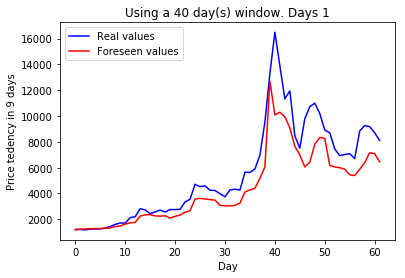

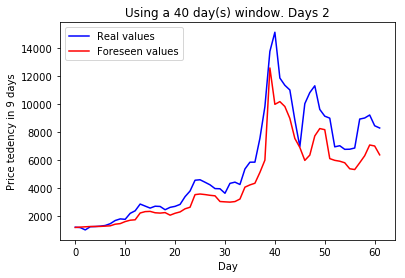

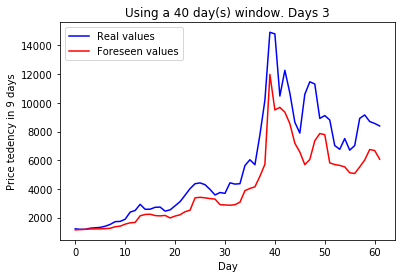

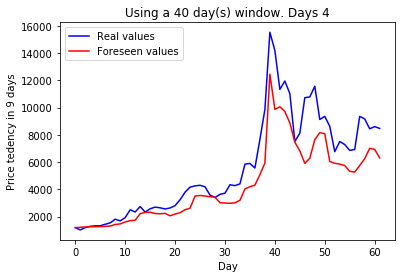

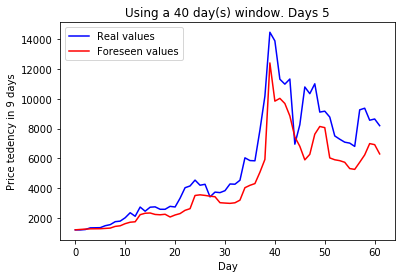

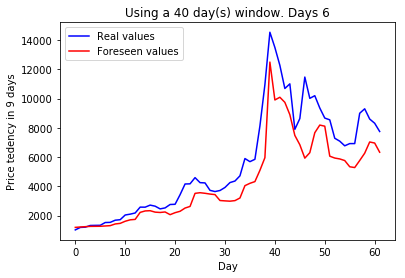

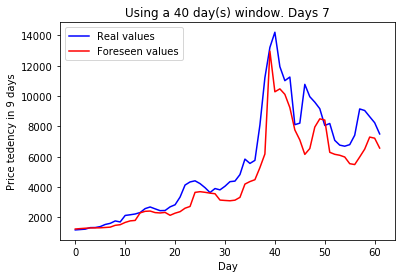

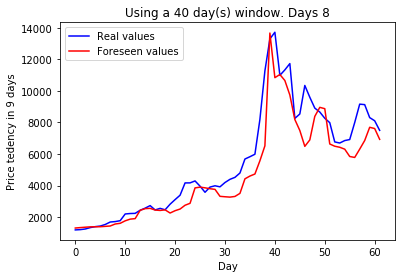

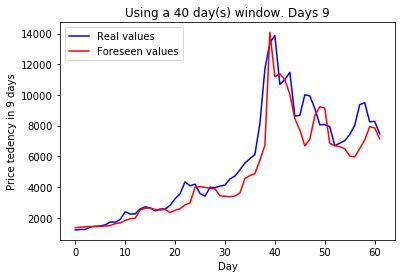

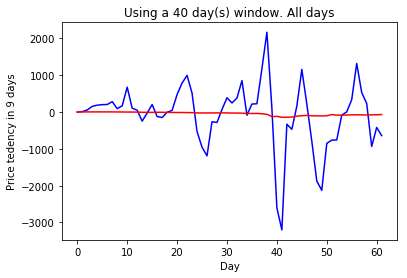

In [116]:
for i in xrange(days):
    mc = y_test3[i,0]/pred3[i, 0]
    plt.plot(y_test3[:,i], c='b', label="Real values")
    plt.plot(pred3[:,i] * mc , c='r', label="Foreseen values")
    plt.title("Using a %s day(s) window. Days %s"%(span, i+1))
    plt.xlabel("Day")
    plt.ylabel("Price tedency in %s days"%days)
    plt.legend(loc='best')
    plt.show()
    
plt.plot(y_test3[:, -1] - y_test3[:, 0], c='b')
plt.plot(pred3[:, -1]- pred3[:, 0], c='r')
plt.title("Using a %s day(s) window. All days"%span)
plt.xlabel("Day")
plt.ylabel("Price tedency in %s days"%days)

plt.show()


day 1 ac: 96.09%
day 2 ac: 95.06%
day 3 ac: 92.80%
day 4 ac: 91.61%
day 5 ac: 91.30%
day 6 ac: 92.29%
day 7 ac: 90.72%
day 8 ac: 90.76%
day 9 ac: 88.84%


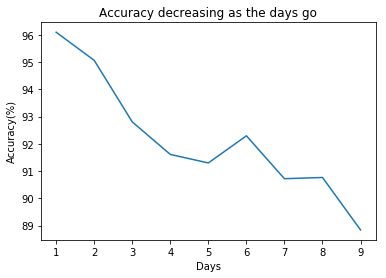

In [18]:
ac = []
xl = range(1, days+1)
for i in xrange(days):
    ac.append(100*r2_score(y_test3[:, i], pred3[:,i]))
    print "day %s ac: %.2f%%"%(i+1, ac[i] )
plt.plot(xl, ac)
plt.title("Accuracy decreasing as the days go")
plt.xlabel("Days")
plt.ylabel("Accuracy(%)")
plt.show()


Pearson coef: 


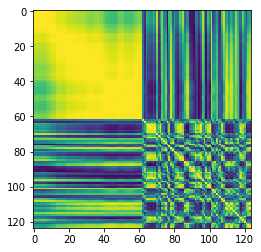

0 0.9684813995790109
1 0.9677153014021348
2 0.96289015737371
3 0.9672436101367284
4 0.9624805642749285
5 0.9615841890782315
6 0.9559352668909652
7 0.9548922356822522
8 0.9476206385179792


In [130]:
print "Pearson coef: "
plt.imshow(np.corrcoef(pred3, y_test3, ))
plt.show()
for i in xrange(days):
    print i, np.corrcoef(pred3[:, i], y_test3[:, i])[0,1]


### Joing the two worlds

In [82]:
regmd =  MLPRegressor(algorithm='adam', alpha=0.01, hidden_layer_sizes=(100), random_state=None,
                verbose=False, max_iter=30000, shuffle=False, tol=1e-10, early_stopping=False,
                   momentum=0.9)


class mpred():
    def __init__(self, reg):
        self.reg = reg 
        self.all_predictors = []
    
    def fit(self, X, y):
        for i in xrange(y.shape[1]):
            self.reg.fit(X, y[:, i])
            self.all_predictors.append(copy.copy(self.reg))
            print "next-->"
        print "All trained!"
    def score(self,X, y):
        sc = []
        for i,j in zip(self.all_predictors, xrange(len(self.all_predictors))):
            sc.append(i.score(X, y[:, j]))
        return sc
    
    def predict(self, X):
        pred = []
        for i,j in zip(self.all_predictors, xrange(len(self.all_predictors))):
            pred.append(i.predict(X))
        return np.vstack(pred).T

regm = mpred(regmd)
regm.fit(X_train_std3, y_train3)  

next-->
next-->
next-->
next-->
next-->
next-->
next-->
next-->
next-->
All trained!


In [86]:
print"Validation score: ", regm.score(X_validation_std3, y_validation3), "\n"
td =  tendence_score(y_validation3, regm.predict(X_validation_std3))
print "validation tendence score", td, td.mean(), "\n"

etd =  end_tendence_score(y_validation3, regm.predict(X_validation_std3))
print "validation end tendence score", etd, "\n"

me = mean_error(y_validation3,regm.predict(X_validation_std3))
print"Mean error for validation", me, me.mean(),

Validation score:  [0.9913209970286363, 0.9793674205508198, 0.9669509589790918, 0.9519703097580761, 0.9469311788947696, 0.9218343969538704, 0.9038528781850048, 0.8840220525373779, 0.8789711397441972] 

validation tendence score [0.70967742 0.77419355 0.70967742 0.64516129 0.72580645 0.69354839
 0.69354839 0.70967742 0.66129032] 0.7025089605734768 

validation end tendence score 0.8064516129032258 

Mean error for validation [232.66018917 410.34834129 516.14577208 494.14213619 641.92217759
 751.13801063 802.93500235 931.46237957 980.94280488] 640.1885348614641


In [87]:
predm = reg3.predict(X_test_std3)
#print regm.score(X_test_std3, y_test3)
print"test score: ", regm.score(X_test_std3, y_test3), "\n"

td =  tendence_score(y_test3, predm)
print "test tendence score", td, td.mean(), "\n"

etd =  end_tendence_score(y_test3, predm)
print "test end tendence score", etd, "\n"

me = mean_error(y_test3, predm)
print"Mean error for test", me, me.mean()

test score:  [0.9734941899266966, 0.9566919854838577, 0.9290306637932365, 0.9269850017212943, 0.9153720268893344, 0.9209275981044712, 0.9092896023770135, 0.908683340607219, 0.8943040214531478] 

test tendence score [0.77419355 0.66129032 0.64516129 0.72580645 0.67741935 0.62903226
 0.61290323 0.74193548 0.67741935] 0.6827956989247312 

test end tendence score 0.7903225806451613 

Mean error for test [496.3281846  564.25747584 682.60015671 766.73278858 781.1408861
 770.1904533  782.77892214 785.55639797 838.16282614] 718.6386768200186


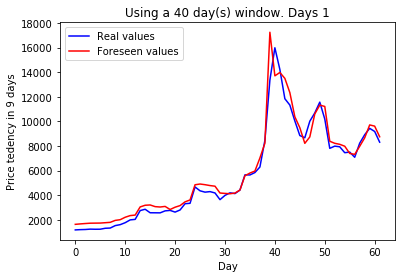

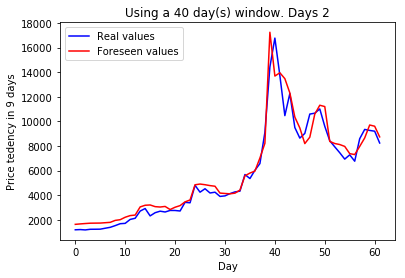

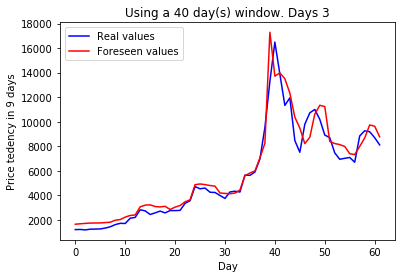

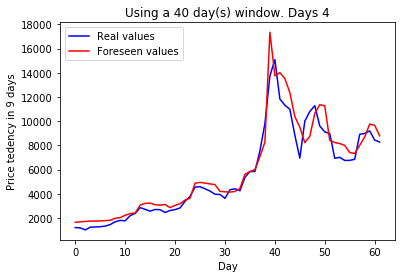

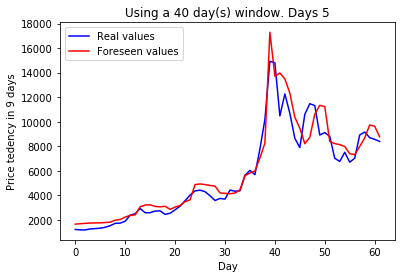

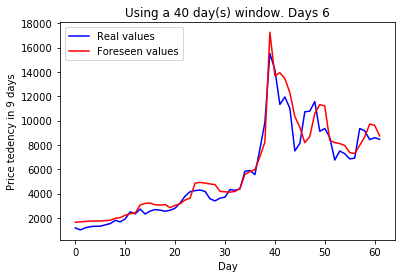

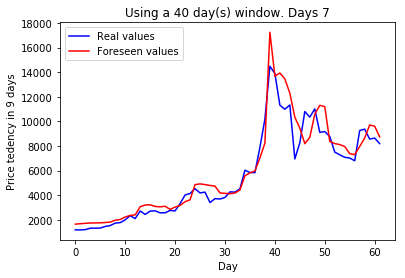

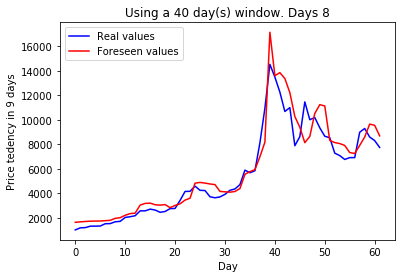

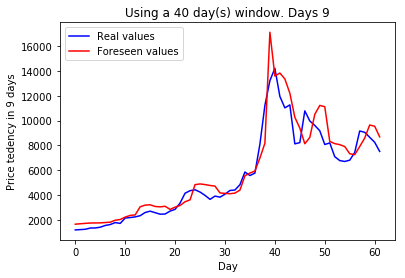

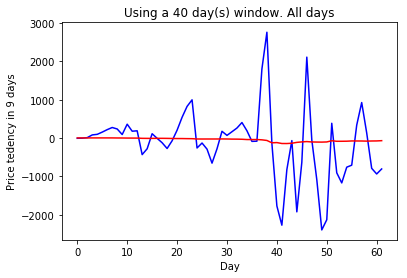

In [88]:
for i in xrange(days):

    plt.plot(y_test3[:,i], c='b', label="Real values")
    plt.plot(predm[:, i] , c='r', label="Foreseen values")
    plt.title("Using a %s day(s) window. Days %s"%(span, i+1))
    plt.xlabel("Day")
    plt.ylabel("Price tedency in %s days"%days)
    plt.legend(loc='best')
    plt.show()
    
plt.plot(y_test3[:, -1] - y_test3[:, 0], c='b')
plt.plot(predm[:, -1]- predm[:, 0], c='r')
plt.title("Using a %s day(s) window. All days"%span)
plt.xlabel("Day")
plt.ylabel("Price tedency in %s days"%days)

plt.show()

## Testing my results

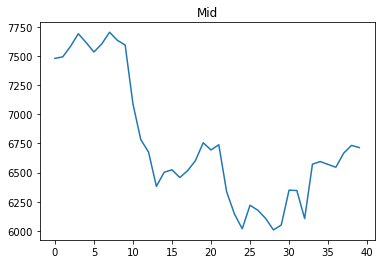

(1, 40)


In [23]:
mid_ = alll[-span:].values.reshape(1,-1)

plt.plot(mid_[0,:])
plt.title("Mid")
plt.show()
print mid_.shape

In [44]:
Xf_std = scaler.transform(mid_)
print Xf_std.shape
print df.Date.values[-1]
ct = 25050/mid_[0,-1]#brl cte corrected by the walltime Inc. price at the time, 22:00, 2018-07-10
print "Rate(usd to brl)", ct

(1, 40)
2018-07-08
Rate(usd to brl) 3.730820850848745


#### For n-days predictions (Best in accuracy)

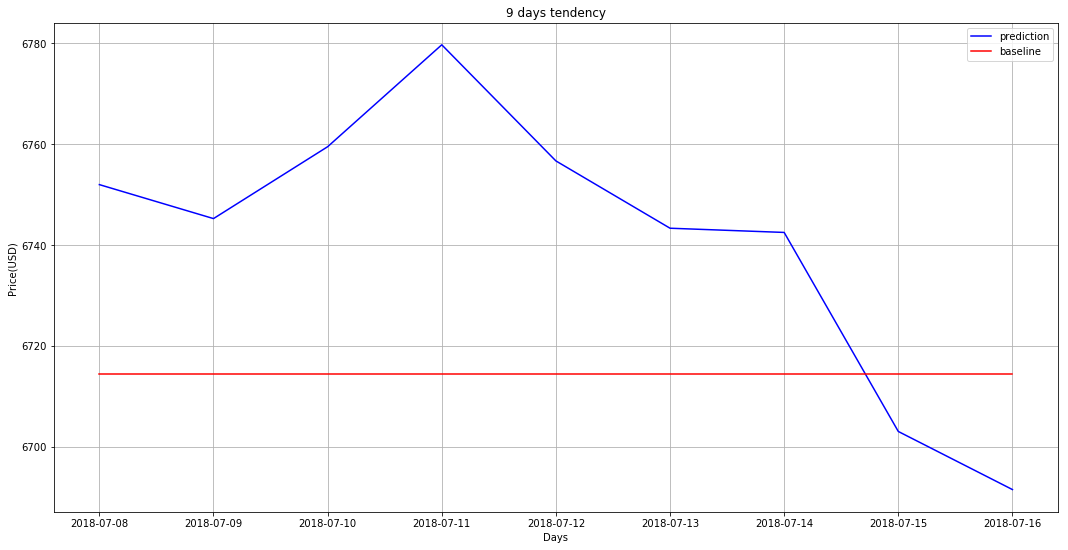

Prediction for 9 days from now: 6691.46
Delta from today to then: -22.88


In [45]:
final_prof = reg3.predict(Xf_std)
baseline = np.ones(final_prof.shape[1]) * mid_[0,-1]
datelist = pd.date_range(datetime.datetime.strptime(df.Date.values[-1], "%Y-%m-%d"), periods=days).values
#datelist = df.Date.values[-days:]
plt.figure(figsize = (18,9))
plt.plot(datelist, final_prof[0,:], c="b", label="prediction")
plt.plot(datelist, baseline, c="r", label="baseline")
plt.title("%s days tendency"%days)
plt.xlabel("Days")
plt.ylabel("Price(USD)")
plt.legend(loc="best")
plt.grid()
plt.show()
print "Prediction for %s days from now: %.2f"%(days, final_prof[0,-1])
print "Delta from today to then: %.2f"%(final_prof[0, -1] - mid_[0,-1])

In BRL


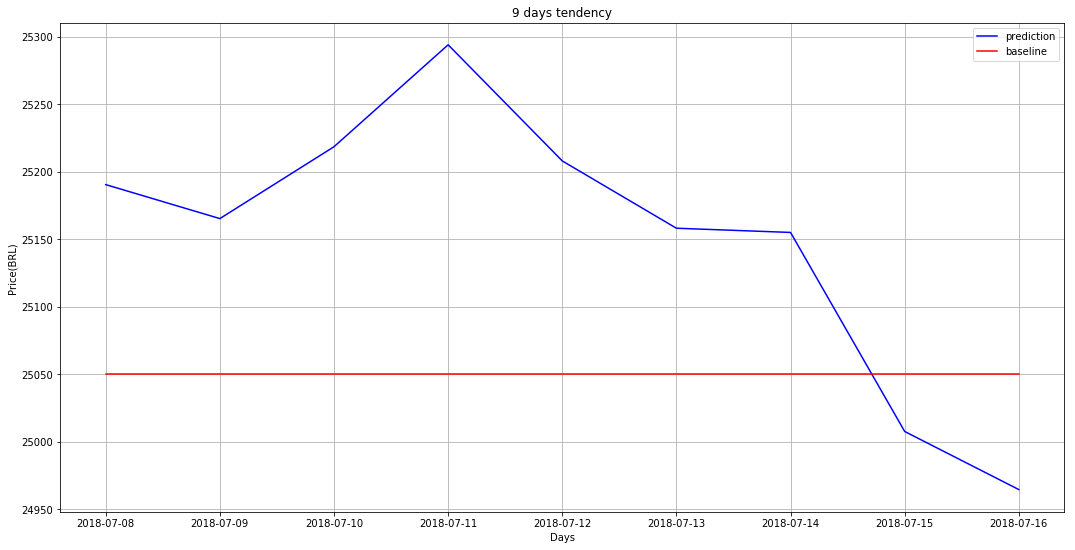

Prediction for 9 days from now: BRL 24964.63
Delta from today to then: BRL -85.37


In [46]:
print "In BRL"
final_profb = final_prof * ct
baselineb = baseline * ct
plt.figure(figsize = (18,9))
plt.plot(datelist, final_profb[0,:], c="b", label="prediction")
plt.plot(datelist, baselineb, c="r", label="baseline")
plt.title("%s days tendency"%days)
plt.xlabel("Days")
plt.ylabel("Price(BRL)")
plt.legend(loc="best")
plt.grid()
plt.show()
print "Prediction for %s days from now: BRL %.2f"%(days, final_profb[0,-1])
print "Delta from today to then: BRL %.2f"%( final_profb[0, -1] - (mid_[0,-1]*ct) )


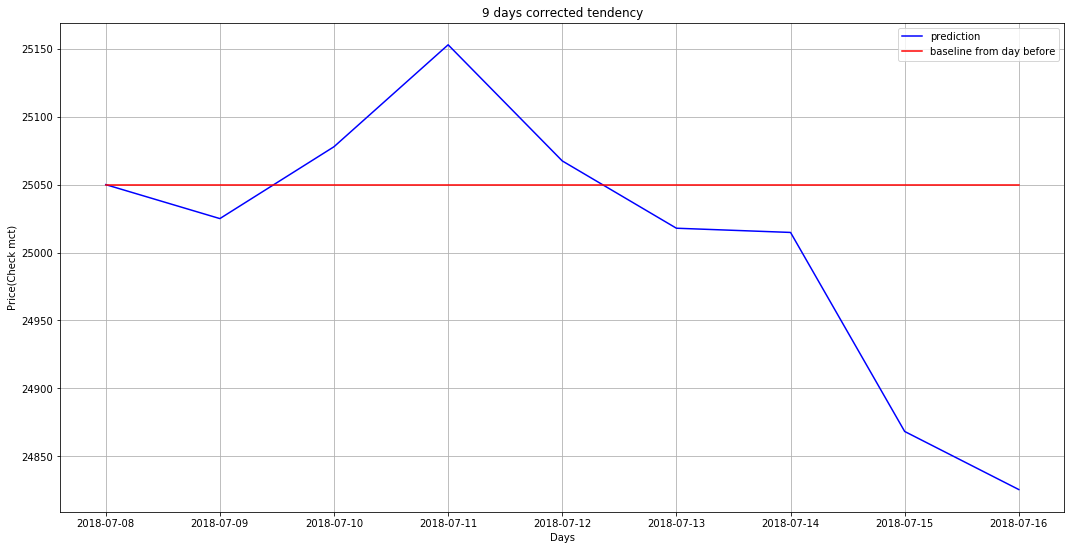

Corrected prediction for 9 days from now: 24825.49 (check mct)
Corrected delta from today to then: -224.51 (check mct)


In [47]:
# Correcting the values to the tendency (Matching the predicted to the real to see the 'real' tendency only)


mct = ct # change to 1 for no correction
rea_t_cte = mid_[0,-1]/final_prof[0,0]

plt.figure(figsize = (18,9))
plt.plot(datelist, final_prof[0,:]*rea_t_cte * mct , c="b", label="prediction")
plt.plot(datelist, baseline * mct, c="r", label="baseline from day before")
plt.title("%s days corrected tendency"%days)
plt.xlabel("Days")
plt.ylabel("Price(Check mct)")
plt.legend(loc="best")
plt.grid()
plt.show()
print "Corrected prediction for %s days from now: %.2f (check mct)"%(days, final_prof[0,-1]* rea_t_cte  * mct)
print "Corrected delta from today to then: %.2f (check mct)"%((final_prof[0, -1]*rea_t_cte - mid_[0,-1])*mct)


## best of the two worlds

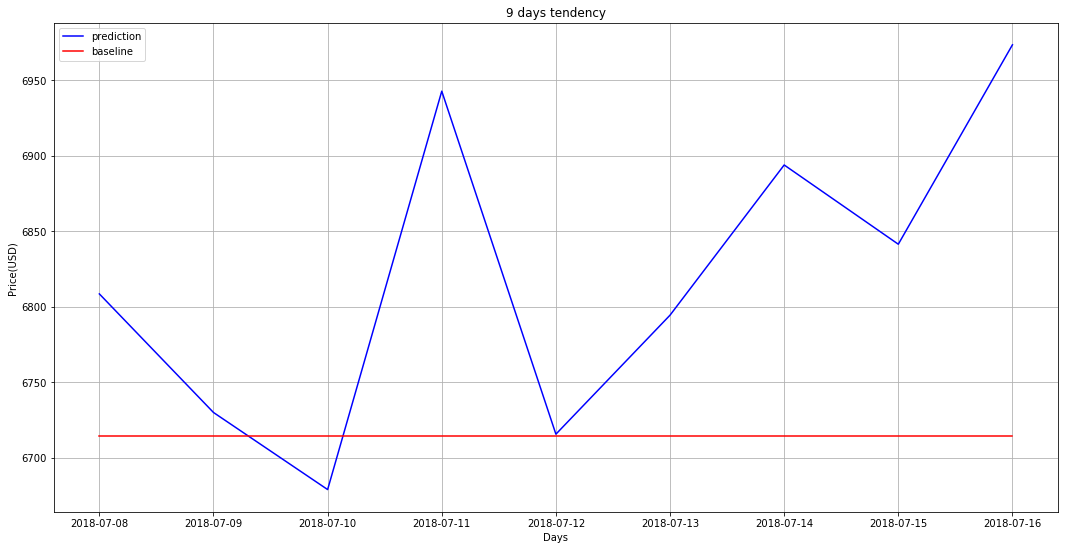

Prediction for 9 days from now: 6973.53
Delta from today to then: 259.19


In [89]:
final_prof = regm.predict(Xf_std)
baseline = np.ones(final_prof.shape[1]) * mid_[0,-1]
datelist = pd.date_range(datetime.datetime.strptime(df.Date.values[-1], "%Y-%m-%d"), periods=days).values
#datelist = df.Date.values[-days:]
plt.figure(figsize = (18,9))
plt.plot(datelist, final_prof[0,:], c="b", label="prediction")
plt.plot(datelist, baseline, c="r", label="baseline")
plt.title("%s days tendency"%days)
plt.xlabel("Days")
plt.ylabel("Price(USD)")
plt.legend(loc="best")
plt.grid()
plt.show()
print "Prediction for %s days from now: %.2f"%(days, final_prof[0,-1])
print "Delta from today to then: %.2f"%(final_prof[0, -1] - mid_[0,-1])

In BRL


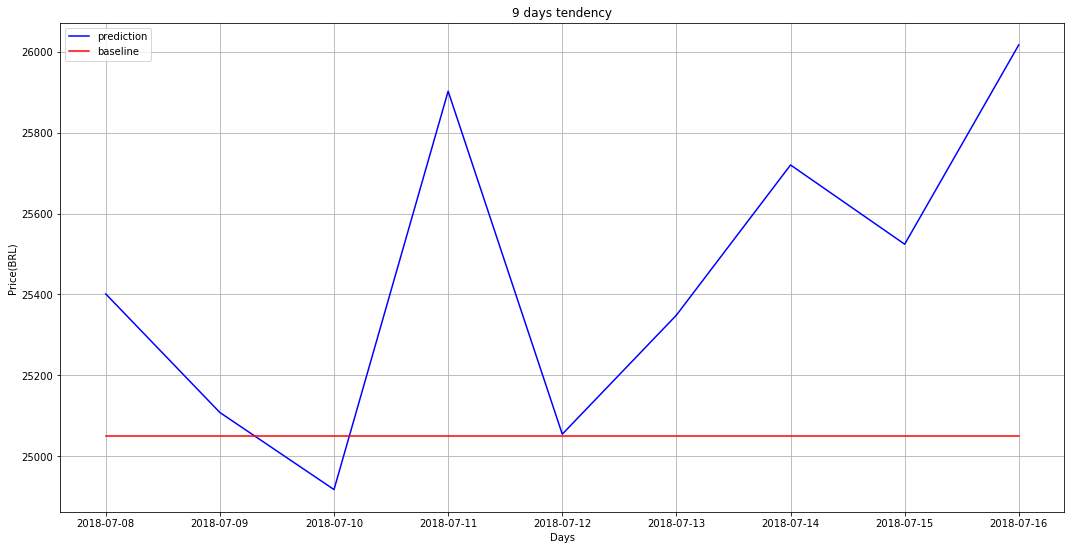

Prediction for 9 days from now: BRL 26017.01
Delta from today to then: BRL 967.01


In [90]:
print "In BRL"
final_profb = final_prof * ct
baselineb = baseline * ct
plt.figure(figsize = (18,9))
plt.plot(datelist, final_profb[0,:], c="b", label="prediction")
plt.plot(datelist, baselineb, c="r", label="baseline")
plt.title("%s days tendency"%days)
plt.xlabel("Days")
plt.ylabel("Price(BRL)")
plt.legend(loc="best")
plt.grid()
plt.show()
print "Prediction for %s days from now: BRL %.2f"%(days, final_profb[0,-1])
print "Delta from today to then: BRL %.2f"%( final_profb[0, -1] - (mid_[0,-1]*ct) )


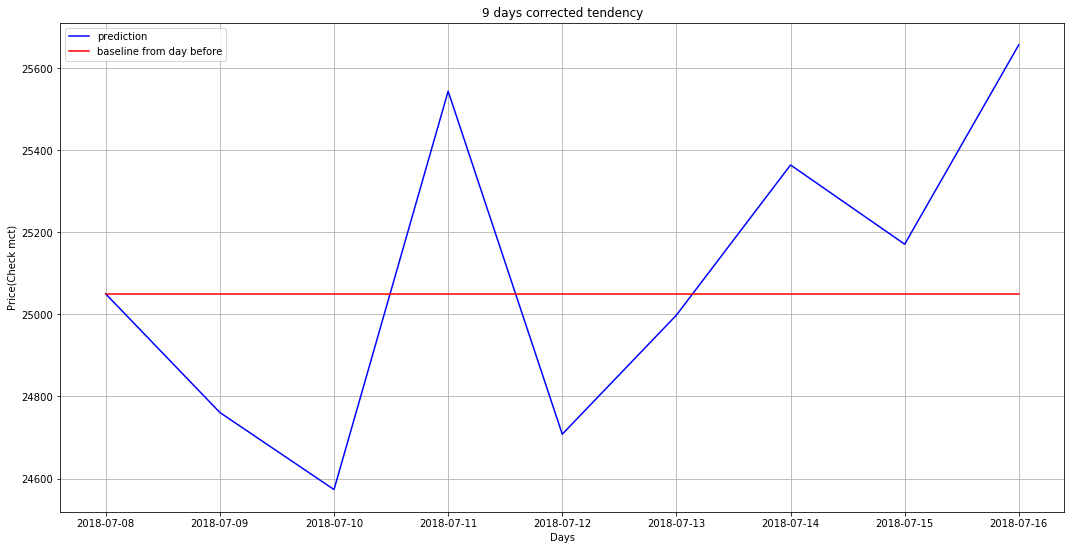

Corrected prediction for 9 days from now: 25657.20 (check mct)
Corrected delta from today to then: 607.20 (check mct)


In [91]:
# Correcting the values to the tendency (Matching the predicted to the real to see the 'real' tendency only)

mct = ct # change to 1 for no correction
rea_t_cte = mid_[0,-1]/final_prof[0,0]

plt.figure(figsize = (18,9))
plt.plot(datelist, final_prof[0,:]*rea_t_cte * mct , c="b", label="prediction")
plt.plot(datelist, baseline * mct, c="r", label="baseline from day before")
plt.title("%s days corrected tendency"%days)
plt.xlabel("Days")
plt.ylabel("Price(Check mct)")
plt.legend(loc="best")
plt.grid()
plt.show()
print "Corrected prediction for %s days from now: %.2f (check mct)"%(days, final_prof[0,-1]* rea_t_cte  * mct)
print "Corrected delta from today to then: %.2f (check mct)"%((final_prof[0, -1]*rea_t_cte - mid_[0,-1])*mct)


#### One day prediction (2nd best in accuracy)

In [51]:
mer = mean_error(pred, y_test)
print "Value today: USD %.2f"% mid_[0,-1]
print "Prediction for %s  days from now (now: %s): USD %.2f +- %.2f"%(days, df.Date.values[-1], reg1.predict(Xf_std)[0], mer)
print "Delta from today to then: USD %.2f"%(reg1.predict(Xf_std)[0] - mid_[0,-1] )


Value today: USD 6714.34
Prediction for 9  days from now (now: 2018-07-08): USD 6756.52 +- 973.08
Delta from today to then: USD 42.18


In [52]:
print "In BRL"
print "Value today: BRL %.2f"%(mid_[0,-1] *ct)
print "Prediction for %s days from now (now: %s): BRL %.2f +- %.2f"%(days, df.Date.values[-1], ct * reg1.predict(Xf_std)[0], mer * ct)
print "Delta from today to then: BRL %.2f"%((reg1.predict(Xf_std)[0] - mid_[0,-1]) * ct)


In BRL
Value today: BRL 25050.00
Prediction for 9 days from now (now: 2018-07-08): BRL 25207.37 +- 3630.38
Delta from today to then: BRL 157.37
